In [ ]:
import plotly.io as pio
# To render plotly figures in Jupyter Notebooks
pio.renderers.default = "notebook"

## Survival analysis

**Author**: Hannou Fatima Zahra
<br/>
**Date**: 02/12/2024

---

**Table of contents**<a id='toc0_'></a>    
- [Data](#toc1_1_)    
    - [Loading the data](#toc1_1_1_)    
    - [Data types](#toc1_1_2_)    
    - [NaN values check](#toc1_1_3_)    
    - [Duplicates check](#toc1_1_4_)    
    - [Input and output variables](#toc1_1_5_)    
    - [Split the data](#toc1_1_6_)    
    - [Data preprocessing](#toc1_1_7_)    
      - [Encoding categorical features](#toc1_1_7_1_)    
    - [Exploratory data analysis](#toc1_1_8_)    
      - [Unique patients](#toc1_1_8_1_)    
      - [CD4 count measurements per patient](#toc1_1_8_2_)    
      - [Visualization of censored and non-censored patients](#toc1_1_8_3_)    
      - [Distribution of numerical variables](#toc1_1_8_4_)    
      - [CD4 distribution across categorical variables](#toc1_1_8_5_)    
      - [Distribution of categorical variables](#toc1_1_8_6_)    
      - [Correlation matrix](#toc1_1_8_7_)    
      - [CD4 analysis](#toc1_1_8_8_)    
      - [Survival function](#toc1_1_8_9_)    
    - [Log-Rank test](#toc1_1_9_)    
  - [Training with Cox](#toc1_2_)    
    - [Variant 1 : Linear relationship](#toc1_2_1_)    
      - [Create Train / Test dataframes](#toc1_2_1_1_)    
      - [Create Cox model](#toc1_2_1_2_)    
      - [Fit Cox model](#toc1_2_1_3_)    
      - [Print summary of the results](#toc1_2_1_4_)    
      - [Test the model](#toc1_2_1_5_)    
      - [Log hazard ratios](#toc1_2_1_6_)    
      - [Partial effects on outcome](#toc1_2_1_7_)    
        - [CD4](#toc1_2_1_7_1_)    
        - [Treatment](#toc1_2_1_7_2_)    
        - [Sex](#toc1_2_1_7_3_)    
        - [Previous infection](#toc1_2_1_7_4_)    
        - [AZT](#toc1_2_1_7_5_)    
    - [Variant 2 : Complex relationship](#toc1_2_2_)    
      - [Print summary of the results](#toc1_2_2_1_)    
      - [Test the model](#toc1_2_2_2_)    
    - [Compare the scores for the 2 variants](#toc1_2_3_)    
  - [Training with Random Survival Forest](#toc1_3_)    
    - [Encoding numerical features](#toc1_3_1_)    
    - [Variant 1 : Default hyperparameters](#toc1_3_2_)    
      - [Concordance index](#toc1_3_2_1_)    
      - [Factors importance](#toc1_3_2_2_)    
      - [Brier score](#toc1_3_2_3_)    
    - [Variant 2 : Hyperparameter tuning](#toc1_3_3_)    
  - [Interpretation of the fitted models](#toc1_4_)    
    - [Survival probability beyond 18 months](#toc1_4_1_)    
    - [Conditional survival probability](#toc1_4_2_)    
  - [Conclusion](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [89]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

## <a id='toc1_1_'></a>[Data](#toc0_)

### <a id='toc1_1_1_'></a>[Loading the data](#toc0_)

In [90]:
import pandas as pd

df = pd.read_csv("./hiv.csv")
df.head()

,subject,time,death,cd4,time_obs,treatment,sex,prev_infection,azt
0,1,16.97,0,10.677078,0,ddC,male,AIDS,intolerance
1,1,16.97,0,8.426150,6,ddC,male,AIDS,intolerance
2,1,16.97,0,9.433981,12,ddC,male,AIDS,intolerance
3,2,19.00,0,6.324555,0,ddI,male,noAIDS,intolerance
4,2,19.00,0,8.124038,6,ddI,male,noAIDS,intolerance


### <a id='toc1_1_2_'></a>[Data types](#toc0_)

In [91]:
df.dtypes

subject             int64
time              float64
death               int64
cd4               float64
time_obs            int64
treatment          object
sex                object
prev_infection     object
azt                object
dtype: object

### <a id='toc1_1_3_'></a>[NaN values check](#toc0_)

In [92]:
number_of_missing_values = df.isna().sum().sum()
print(f"Number of missing values: {number_of_missing_values}")

Number of missing values: 0


### <a id='toc1_1_4_'></a>[Duplicates check](#toc0_)

In [93]:
duplicates = df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 0


### <a id='toc1_1_5_'></a>[Input and output variables](#toc0_)

We are preparing the feature set (`x`) and the target array (`y`) for use in survival analysis. The data is properly formatted for models like `Cox regression` and `Random Survival Forest`.

In [94]:
import numpy as np

x = df.drop(['time', 'death'], axis=1)
y = np.zeros(len(x), dtype=[('death', bool), ('time', float)])

y['death'] = df['death'].astype(bool)
y['time'] = df['time']

### <a id='toc1_1_6_'></a>[Split the data](#toc0_)

We are spliting the data into training and testing sets using `StratifiedShuffleSplit`, ensuring the distribution of the `death` column (event occurrence) is preserved.

Stratifying by `death` is important because it accounts for censored patients, maintaining the same proportion of events and non-events in both sets.

In [95]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(x, y['death']):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

print("Train set - Death rate:", np.mean(y_train['death']))
print("Test set  - Death rate:", np.mean(y_test['death']))

Train set - Death rate: 0.29359430604982206
Test set  - Death rate: 0.2918149466192171


### <a id='toc1_1_7_'></a>[Data preprocessing](#toc0_)

We are encoding the categorical features to numerical values.

#### <a id='toc1_1_7_1_'></a>[Encoding categorical features](#toc0_)

In [96]:
from sklearn.preprocessing import OrdinalEncoder

categorical_cols = ['treatment', 'sex', 'prev_infection', 'azt']

encoder = OrdinalEncoder()
encoder.fit(x_train[categorical_cols])

x_train.loc[:, categorical_cols] = encoder.transform(x_train[categorical_cols])
x_test.loc[:, categorical_cols] = encoder.transform(x_test[categorical_cols])

In [97]:
x_train.head()

,subject,cd4,time_obs,treatment,sex,prev_infection,azt
834,274,4.358899,18,1.0,1.0,0.0,0.0
221,79,2.828427,12,0.0,1.0,1.0,1.0
257,90,16.911535,6,1.0,1.0,1.0,1.0
186,68,8.831761,2,1.0,1.0,0.0,0.0
1101,361,0.000000,0,1.0,1.0,0.0,0.0


### <a id='toc1_1_8_'></a>[Exploratory data analysis](#toc0_)

#### <a id='toc1_1_8_1_'></a>[Unique patients](#toc0_)

In [98]:
df_unique = df.groupby("subject").first()
n_unique_patients = len(df_unique)
print("Number of unique patients:", n_unique_patients)

Number of unique patients: 467


#### <a id='toc1_1_8_2_'></a>[CD4 count measurements per patient](#toc0_)

In [99]:
cd4_counts_per_patient = df.groupby('subject')['cd4'].count()

print("\nCD4 Counts per Patient:")
print("Mean CD4 Counts per Patient  :", int(cd4_counts_per_patient.mean()))
print("Median CD4 Counts per Patient:", int(cd4_counts_per_patient.median()))
print("Min CD4 Counts per Patient   :", cd4_counts_per_patient.min())
print("Max CD4 Counts per Patient   :", cd4_counts_per_patient.max())


CD4 Counts per Patient:
Mean CD4 Counts per Patient  : 3
Median CD4 Counts per Patient: 3
Min CD4 Counts per Patient   : 1
Max CD4 Counts per Patient   : 5


#### <a id='toc1_1_8_3_'></a>[Visualization of censored and non-censored patients](#toc0_)

The plot shows the survival times of 15 patients. Each horizontal line represents a single patient, and the length of the line indicates how long they survived. Blue dots mark the time of death for patients whose death was observed, while black dots represent patients who were lost to follow-up (censored). Red crosses indicate the time of censoring for these patients. The vertical dashed line at 18 months marks the end of the study period. 

Overall, the plot suggests that survival times varied among patients. Some patients survived for a relatively short time, while others survived for much longer. The presence of censored observations means that the true survival times of some patients are unknown, which can impact the accuracy of survival estimates. 

In [100]:
import plotly.graph_objects as go

unique_patients = df.drop_duplicates(subset='subject')
subset_patients = unique_patients.head(15)

subjects_death_observed = []
times_death_observed = []

subjects_death_unobserved = []
times_death_unobserved = []

subjects_censored = []
times_censored = []

for _, patient in subset_patients.iterrows():
    if patient['death'] == 1:
        if patient['time'] <= 18:
            # Observed death
            subjects_death_observed.append(patient['subject'])
            times_death_observed.append(patient['time'])
        else:
            # Unobserved death
            subjects_death_unobserved.append(patient['subject'])
            times_death_unobserved.append(patient['time'])
    else:
        # Censored
        subjects_censored.append(patient['subject'])
        times_censored.append(patient['time'])

fig = go.Figure()

# Add gray lines for follow-up period (patients)
for _, patient in subset_patients.iterrows():
    fig.add_trace(go.Scatter(
        x=[0, patient['time']],
        y=[patient['subject'], patient['subject']],
        mode='lines',
        line=dict(color='gray', width=5),
        showlegend=False
    ))

fig.add_trace(go.Scatter(
    x=times_death_observed,
    y=subjects_death_observed,
    mode='markers',
    marker=dict(color='blue', size=10, symbol='circle', line=dict(width=1)),
    name='Death (observed)'
))

fig.add_trace(go.Scatter(
    x=times_death_unobserved,
    y=subjects_death_unobserved,
    mode='markers',
    marker=dict(color='black', size=10, symbol='circle',
                opacity=1, line=dict(color='black', width=2)),
    name='Death (unobserved)'
))

fig.add_trace(go.Scatter(
    x=times_censored,
    y=subjects_censored,
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='Censoring'
))

fig.add_vline(x=18, line=dict(color='black', dash='dash'), name='End of Study')

fig.update_layout(
    title={
        'text': 'Visualization of censored and non-censored patients - First 15 patients',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    plot_bgcolor='white',
    width=1000,
    height=600,
    margin=dict(l=80, r=50, b=80, t=150),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.125,
        xanchor='center',
        x=0.5
    ),
    xaxis=dict(
        title='Time (months)',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1,
        linecolor='black',
        linewidth=1,
        tickvals=[0, 2, 6, 12, 18, 26]
    ),
    yaxis=dict(
        title='Patients',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1,
        linecolor='black',
        linewidth=1,
        tickvals=list(range(1, 16))
    )
)

fig.update_traces(
    hovertemplate='<b>%{fullData.name}</b><br>Patient: %{y}<br>Time: %{x} months<extra></extra>'
)

fig.show()
fig.write_image("censored_patients_and_non_censored_patients.svg")

Some patients died after the study concluded and were recorded in the dataset as death, indicated by a value of 1 in the `death` column. However, for the purposes of this study, we will classify them as censored patients since the event occurred after the study's completion.

In [101]:
indices_for_patients_died_after_end_of_study = df[(
    df['death'] == 1) & (df['time'] > 18)].index
df.loc[indices_for_patients_died_after_end_of_study, 'death'] = 0

#### <a id='toc1_1_8_4_'></a>[Distribution of numerical variables](#toc0_)

- **Time Distribution:** The time distribution shows a bell-shaped curve, with a peak occurring around 13.
- **CD4 Count Distribution:** The CD4 count distribution is right-skewed, with a peak near 4. The CD4 values range from 0 to 24.
- **Observation Time Distribution:** The plot suggests a decrease in the number of measurements over time, possibly due to patients no longer attending or some having passed away.

In [102]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=('Time Distribution', 'CD4 Count Distribution',
                    'Observation Time Distribution'),
    horizontal_spacing=0.1
)

fig.add_trace(
    go.Histogram(
        x=df['time'],
        name='Time',
        marker_color='#2C7BB6',
        opacity=0.7,
        histnorm='probability density',
        nbinsx=20,
    ),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(
        x=df['cd4'],
        name='CD4 Count',
        marker_color='#D7191C',
        opacity=0.7,
        histnorm='probability density',
        nbinsx=20,
    ),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(
        x=df['time_obs'],
        name='Observation Time',
        marker_color='#78C679',
        opacity=0.7,
        histnorm='probability density',
        nbinsx=20,
    ),
    row=1, col=3,
)

fig.update_layout(
    title={
        'text': 'Distribution of numerical variables',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    plot_bgcolor='white',
    width=1500,
    height=500,
    margin=dict(l=80, r=50, b=80, t=150),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.125,
        xanchor='center',
        x=0.5
    )
)

fig.update_xaxes(
    showgrid=True,
    gridcolor='lightgrey',
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=1,
    linecolor='black',
    linewidth=1,
)

fig.update_yaxes(
    title_text='Probability density',
    showgrid=True,
    gridcolor='lightgrey',
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=1,
    linecolor='black',
    linewidth=1,
)

fig.update_traces(
    hovertemplate='<b>%{fullData.name}</b><br>Value: %{x:.2f}<br>Density: %{y:.4f}<extra></extra>'
)

fig.show()
fig.write_image("numerical_variables_distribution.svg")

#### <a id='toc1_1_8_5_'></a>[CD4 distribution across categorical variables](#toc0_)

This plot contains four box plots that show the distribution of CD4 counts across different categorical variables.

1. **CD4 by Treatment (Top left)**
   - **ddC**: The median CD4 count is around 5. The interquartile range (IQR) is roughly from 3 to 10. There are some outliers above 20.
   - **ddI**: The median CD4 count is slightly higher than ddC, around 5.9. The IQR is from about 3 to 11. There are also outliers above 21.

2. **CD4 by Sex (Top right)**
   - **Male**: The median CD4 count is around 5.4. The IQR is from about 3 to 10. There are outliers above 20.
   - **Female**: The median CD4 count is slightly higher than males, around 6.3. The IQR is from about 3.4 to 12.8.

3. **CD4 by Previous Infection (Bottom left)**
   - **AIDS**: The median CD4 count is around 4. The IQR is from about 2.6 to 6.8. There are outliers above 13.
   - **noAIDS**: The median CD4 count is higher, around 10. The IQR is from about 5 to 14.

4. **CD4 by AZT (Bottom right)**
   - **Intolerance**: The median CD4 count is around 6.5. The IQR is from about 3.6 to 12.
   - **Failure**: The median CD4 count is lower, around 4. The IQR is from about 2.6 to 7.8. There are outliers above 12.6.

**General Observations:**
- In all plots, there are some outliers.
- The median CD4 counts tend to be higher in the categories ddI, Female, noAIDS, and Intolerance.
- The categories ddC, Male, AIDS, and Failure generally have lower median CD4 counts.

In [103]:
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(
        'CD4 by Treatment',
        'CD4 by Sex',
        'CD4 by Previous infection',
        'CD4 by AZT'
    )
)

colors = ['#3182bd', '#de2d26', '#31a354', '#756bb1']

fig.add_trace(
    go.Box(
        x=df['treatment'],
        y=df['cd4'],
        name='Treatment',
        marker_color=colors[0],
        boxmean=True
    ),
    row=1, col=1
)

fig.add_trace(
    go.Box(
        x=df['sex'],
        y=df['cd4'],
        name='Sex',
        marker_color=colors[1],
        boxmean=True
    ),
    row=1, col=2
)

fig.add_trace(
    go.Box(
        x=df['prev_infection'],
        y=df['cd4'],
        name='Previous infection',
        marker_color=colors[2],
        boxmean=True
    ),
    row=2, col=1
)

fig.add_trace(
    go.Box(
        x=df['azt'],
        y=df['cd4'],
        name='AZT',
        marker_color=colors[3],
        boxmean=True
    ),
    row=2, col=2
)

fig.update_layout(
    title={
        'text': 'CD4 distribution across categorical variables',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    plot_bgcolor='white',
    width=1200,
    height=800,
    margin=dict(l=80, r=50, b=80, t=100),
    showlegend=False
)

fig.update_xaxes(
    showgrid=True,
    gridcolor='lightgrey',
    linecolor='black',
    linewidth=1,
    tickangle=45
)

fig.update_yaxes(
    title_text='CD4 Count',
    showgrid=True,
    gridcolor='lightgrey',
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=1,
    linecolor='black',
    linewidth=1
)

fig.update_traces(
    hovertemplate='<b>%{x}</b><br>CD4: %{y}<extra></extra>'
)

fig.show()

#### <a id='toc1_1_8_6_'></a>[Distribution of categorical variables](#toc0_)

The plot provides an overview of the distribution of categorical variables in the dataset:

- **Treatment Distribution**:  
  - The counts of **ddC** and **ddI** cases are comparable.
  
- **Sex Distribution**:  
  - **Male** patients are significantly more prevalent (422 cases), with **female** patients being much fewer (45 cases).
  
- **Previous Infection Distribution**:  
  - **AIDS** is the more common status (307 cases), compared to **noAIDS** (160 cases).
  
- **AZT Distribution**:  
  - **Intolerance** to AZT is more frequent (292 cases), while **failure** is less common (175 cases).

The dataset shows notable imbalances, especially regarding sex and the prevalence of certain treatments and previous infections.

In [104]:
unique_data = df[df['time_obs'] == 0]

fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(
        'Distribution of treatment',
        'Distribution of Sex',
        'Distribution of previous infection',
        'Distribution of AZT'
    ),
    vertical_spacing=0.1
)

colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728']
categorical_vars = ['treatment', 'sex', 'prev_infection', 'azt']

for i, var in enumerate(categorical_vars):
    value_counts = unique_data[var].value_counts()

    row = i // 2 + 1
    col = i % 2 + 1

    fig.add_trace(
        go.Bar(
            x=value_counts.index,
            y=value_counts.values,
            name=var.replace('_', ' ').title(),
            marker_color=colors[i],
            text=value_counts.values,
            textposition='outside'
        ),
        row=row,
        col=col
    )

fig.update_layout(
    title={
        'text': 'Distribution of categorical variables (Unique observations)',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    plot_bgcolor='white',
    width=1200,
    height=800,
    margin=dict(l=80, r=50, b=80, t=100),
    showlegend=False
)

fig.update_xaxes(
    showgrid=False,
    linecolor='black',
    linewidth=1,
    tickangle=45
)

fig.update_yaxes(
    title_text='Count',
    showgrid=True,
    gridcolor='lightgrey',
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=1,
    linecolor='black',
    linewidth=1
)

fig.update_traces(
    hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>'
)

fig.show()
fig.write_image("categorical_variables_distribution.svg")

#### <a id='toc1_1_8_7_'></a>[Correlation matrix](#toc0_)

The correlation matrix highlights some notable relationships between variables:

- **Time and previous infection**: A strong positive correlation of **0.25**.
- **Time and death**: A significant negative correlation of **-0.63**.
- **CD4 levels**:  
  - Positively correlated with **time** (**0.21**).
  - Negatively correlated with **death** (**-0.32**), suggesting that higher CD4 levels are associated with better survival outcomes.

In [105]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


encoded_df = df.copy()
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(df[col])

correlation_matrix = encoded_df.corr()

fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    colorbar=dict(
        title='Correlation coefficient',
        titleside='right'
    ),
    text=np.round(correlation_matrix.values, 2),
    texttemplate='%{text:.2f}',
    textfont={"size": 10},
    hoverongaps=False,
))

fig.update_layout(
    title={
        'text': 'Correlation matrix',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    width=1000,
    height=800,
    margin=dict(l=100, r=50, b=100, t=100)
)

fig.update_traces(
    hovertemplate='<b>%{x} vs %{y}</b><br>Correlation: %{z:.2f}<extra></extra>'
)

fig.update_xaxes(tickangle=45)

fig.show()
fig.write_image("correlation_matrix.svg")

#### <a id='toc1_1_8_8_'></a>[CD4 analysis](#toc0_)

In [106]:
sample_patients = df['subject'].unique()[:15]
sample_data = df[df['subject'].isin(sample_patients)]

fig1 = go.Figure()

for i, subject in enumerate(sample_data['subject'].unique()):
    patient_data = sample_data[sample_data['subject'] == subject]
    fig1.add_trace(
        go.Scatter(
            x=patient_data['time_obs'],
            y=patient_data['cd4'],
            mode='lines+markers',
            name=f'Patient {subject}',
            marker=dict(size=8)
        )
    )

fig1.update_layout(
    title={
        'text': 'CD4 Trajectories for Individual Patients',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='CD4 Count',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

cd4_mean = df.groupby('time_obs')['cd4'].mean()
cd4_median = df.groupby('time_obs')['cd4'].median()

fig2 = go.Figure()

# Mean trace
fig2.add_trace(
    go.Scatter(
        x=cd4_mean.index,
        y=cd4_mean.values,
        mode='lines+markers',
        name='CD4 Mean',
        line=dict(color='#1F77B4', width=2),
        marker=dict(size=10, symbol='circle')
    )
)

fig2.add_trace(
    go.Scatter(
        x=cd4_median.index,
        y=cd4_median.values,
        mode='lines+markers',
        name='CD4 Median',
        line=dict(color='#FF7F0E', width=2, dash='dot'),
        marker=dict(size=10, symbol='square')
    )
)

fig2.update_layout(
    title={
        'text': 'Global CD4 Trend Over Time',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='CD4 Count',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

group_means = df.groupby(['time_obs', 'treatment'])['cd4'].mean().unstack()

fig3 = go.Figure()

# Treatment traces
for treatment in group_means.columns:
    fig3.add_trace(
        go.Scatter(
            x=group_means.index,
            y=group_means[treatment],
            mode='lines+markers',
            name=f'Treatment {treatment}',
            line=dict(width=2),
            marker=dict(size=10)
        )
    )

fig3.update_layout(
    title={
        'text': 'CD4 Comparison Across Treatment Groups',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='CD4 Count',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

group_means = df.groupby(['time_obs', 'sex'])['cd4'].mean().unstack()

fig4 = go.Figure()

# Treatment traces
for sex in group_means.columns:
    fig4.add_trace(
        go.Scatter(
            x=group_means.index,
            y=group_means[sex],
            mode='lines+markers',
            name=f'Sex {sex}',
            line=dict(width=2),
            marker=dict(size=10)
        )
    )

fig4.update_layout(
    title={
        'text': 'CD4 Comparison Across Sex',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='CD4 Count',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

group_means = df.groupby(['time_obs', 'azt'])['cd4'].mean().unstack()

fig5 = go.Figure()

# Treatment traces
for azt in group_means.columns:
    fig5.add_trace(
        go.Scatter(
            x=group_means.index,
            y=group_means[azt],
            mode='lines+markers',
            name=f'AZT {azt}',
            line=dict(width=2),
            marker=dict(size=10)
        )
    )

fig5.update_layout(
    title={
        'text': 'CD4 Comparison Across AZT',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='CD4 Count',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

group_means = df.groupby(['time_obs', 'prev_infection'])[
    'cd4'].mean().unstack()

fig6 = go.Figure()

# Treatment traces
for prev_infection in group_means.columns:
    fig6.add_trace(
        go.Scatter(
            x=group_means.index,
            y=group_means[prev_infection],
            mode='lines+markers',
            name=f'Previous infection {prev_infection}',
            line=dict(width=2),
            marker=dict(size=10)
        )
    )

fig6.update_layout(
    title={
        'text': 'CD4 Comparison Across Previous infection',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='CD4 Count',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

fig1.show()

In [107]:
fig2.show()

In [108]:
fig3.show()

In [109]:
fig4.show()

In [110]:
fig5.show()

In [111]:
fig6.show()

#### <a id='toc1_1_8_9_'></a>[Survival function](#toc0_)

**General Observations:**
- The survival probability declines steadily over the 18-month period.
- As time progresses, the confidence interval broadens, indicating increasing uncertainty in the survival estimates.
- The plot visually illustrates the changes in survival probability over time, along with the growing uncertainty in these estimates.

In [112]:
from lifelines import KaplanMeierFitter

kmf_global = KaplanMeierFitter()
kmf_global.fit(df['time'], event_observed=df['death'])

survival_times = kmf_global.survival_function_.index
survival_prob = kmf_global.survival_function_['KM_estimate']
conf_int_lower = kmf_global.confidence_interval_['KM_estimate_lower_0.95']
conf_int_upper = kmf_global.confidence_interval_['KM_estimate_upper_0.95']

fig_global = go.Figure()

fig_global.add_trace(
    go.Scatter(
        x=survival_times,
        y=survival_prob,
        mode='lines',
        name='Survival probability',
        line=dict(color='#1F77B4', width=3),
    )
)

fig_global.add_trace(
    go.Scatter(
        x=np.concatenate([survival_times, survival_times[::-1]]),
        y=np.concatenate([conf_int_upper, conf_int_lower[::-1]]),
        mode='none',
        fill='toself',
        fillcolor='rgba(31, 119, 180, 0.2)',
        name='95% Confidence interval'
    )
)

fig_global.update_layout(
    title={
        'text': 'Overall survival function',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='Survival probability',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)
fig_global.show()

When comparing the survival functions across different groups, we observed the following:
- There is little difference between the groups that received ddC treatment and those that received ddI treatment.
- The same holds for gender, with no significant difference between males and females.
- However, the group without AIDS demonstrated significantly better survival compared to the group with AIDS.
- Similarly, for AZT, the group intolerant to AZT had a better survival function than the group that experienced AZT failure.

In [113]:
from lifelines import KaplanMeierFitter
import plotly.graph_objects as go

categorical_vars = ['treatment', 'sex', 'prev_infection', 'azt']
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B']

for var in categorical_vars:
    fig = go.Figure()

    groups = df[var].unique()
    for j, group in enumerate(groups):
        group_data = df[df[var] == group]

        kmf = KaplanMeierFitter()
        kmf.fit(
            group_data['time'],
            event_observed=group_data['death'],
            label=str(group)
        )

        survival_times = kmf.survival_function_.index
        survival_prob = kmf.survival_function_[
            kmf.survival_function_.columns[0]]

        fig.add_trace(
            go.Scatter(
                x=survival_times,
                y=survival_prob,
                mode='lines',
                name=f'{var} {group}',
                line=dict(color=colors[j % len(colors)], width=2),
                showlegend=True
            )
        )

    fig.update_layout(
        title={
            'text': f'Survival function by {var.replace("_", " ").title()}',
            'font': dict(size=16, family='Arial, bold'),
            'x': 0.5,
            'xanchor': 'center'
        },
        font=dict(family='Arial', size=12),
        width=800,
        height=600,
        plot_bgcolor='white'
    )

    fig.update_xaxes(title_text='Time (months)')
    fig.update_yaxes(title_text='Survival probability')

    fig.show()
    fig.write_image(f"survival_function_by_{var}.svg")

### <a id='toc1_1_9_'></a>[Log-Rank test](#toc0_)

The log-rank tests were used to compare survival functions between different groups. The results indicate that there is no significant difference in survival between patients treated with ddC and ddI or between male and female patients.

However, there is a significant difference in survival between patients with previous AIDS infection and those without, as well as between patients with azt intolerance and those with azt failure. These findings suggest that previous AIDS infection and azt intolerance are associated with worse survival outcomes.

In [114]:
from lifelines.statistics import logrank_test

categorical_columns = ['treatment', 'sex', 'prev_infection', 'azt']
alpha = 0.05

for var in categorical_columns:
    groups = df[var].unique()
    p_values = []

    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            group_1_data = df[df[var] == groups[i]]
            group_2_data = df[df[var] == groups[j]]

            results = logrank_test(
                group_1_data['time'],
                group_2_data['time'],
                event_observed_A=group_1_data['death'],
                event_observed_B=group_2_data['death']
            )

            p_value = results.p_value
            p_values.append((groups[i], groups[j], p_value))

    print(f'Log-rank test results for {var.replace("_", " ").title()}:')
    for group_1, group_2, p_value in p_values:
        result = "There is a significant difference" if p_value < alpha else "There is no significant difference"
        print(f'{group_1} vs {
              group_2}: p-value = {p_value:.4e} -> {result} in survival functions')
    print()

Log-rank test results for Treatment:
ddC vs ddI: p-value = 8.8785e-02 -> There is no significant difference in survival functions

Log-rank test results for Sex:
male vs female: p-value = 7.8397e-01 -> There is no significant difference in survival functions

Log-rank test results for Prev Infection:
AIDS vs noAIDS: p-value = 1.7023e-26 -> There is a significant difference in survival functions

Log-rank test results for Azt:
intolerance vs failure: p-value = 8.7173e-12 -> There is a significant difference in survival functions



## <a id='toc1_2_'></a>[Training with Cox](#toc0_)

We will train two variants of the Cox model: one based on linear relationships between the input variables and the other accounting for more complex, non-linear relationships. Finally, we will compare the performance of these two variants.

### <a id='toc1_2_1_'></a>[Variant 1 : Linear relationship](#toc0_)

#### <a id='toc1_2_1_1_'></a>[Create Train / Test dataframes](#toc0_)

The Cox model requires a dataframe as input, so we are combining the features (X) and target (y) into a single dataframe.

In [115]:
train_df = x_train.copy()
train_df["time"] = y_train["time"]
train_df["death"] = y_train["death"].astype(int)
train_df = train_df.reset_index(drop=True)

test_df = x_test.copy()
test_df["time"] = y_test["time"]
test_df["death"] = y_test["death"].astype(int)
test_df = test_df.reset_index(drop=True)

In [116]:
train_df.head()

,subject,cd4,time_obs,treatment,sex,prev_infection,azt,time,death
0,274,4.358899,18,1.0,1.0,0.0,0.0,19.53,0
1,79,2.828427,12,0.0,1.0,1.0,1.0,12.47,0
2,90,16.911535,6,1.0,1.0,1.0,1.0,17.93,0
3,68,8.831761,2,1.0,1.0,0.0,0.0,14.17,0
4,361,0.000000,0,1.0,1.0,0.0,0.0,6.90,1


#### <a id='toc1_2_1_2_'></a>[Create Cox model](#toc0_)

In [117]:
from lifelines import CoxPHFitter

linear_cox_model = CoxPHFitter()

#### <a id='toc1_2_1_3_'></a>[Fit Cox model](#toc0_)

By setting `show_progress=True`, we can monitor the model's convergence. In our case, the model converged in 5 iterations. Additionally, since we are working with a longitudinal study, we retained all rows and specified `cluster_col='subject'` to instruct the Cox model to cluster the rows for the same patient.

In [118]:
linear_cox_model.fit(
    train_df,
    duration_col='time',
    event_col='death',
    cluster_col='subject',
    show_progress=True
)

Iteration 1: norm_delta = 7.74e-01, step_size = 0.9500, log_lik = -2205.91082, newton_decrement = 1.29e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.78e-01, step_size = 0.9500, log_lik = -2061.62282, newton_decrement = 1.51e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.38e-02, step_size = 0.9500, log_lik = -2045.26599, newton_decrement = 7.00e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.03e-03, step_size = 1.0000, log_lik = -2044.54678, newton_decrement = 1.23e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 7.42e-06, step_size = 1.0000, log_lik = -2044.54555, newton_decrement = 4.37e-09, seconds_since_start = 0.0
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 1124 total observations, 794 right-censored observations>

#### <a id='toc1_2_1_4_'></a>[Print summary of the results](#toc0_)

Here are the key findings:

1. **Significant Predictors**:
   - **CD4 count (cd4)**: Higher CD4 counts significantly reduce the hazard of death (15% decrease per unit increase, p < 0.005).
   - **Observation Time (time_obs)**: Longer observation times are associated with a 15% reduction in hazard per unit increase (p < 0.005).
   - **Previous Infection (prev_infection)**: Not having prior infections significantly reduces the hazard of death by 55% (p < 0.005).

2. **Non-significant Predictors**:
   - **Treatment (treatment)**: The effect of treatment on hazard is uncertain (p = 0.33).
   - **Sex (sex)**: Females are slightly more likely to experience the event. But there is no significant difference in hazard between sexes (p = 0.80).
   - **AZT Treatment (azt)**: The same for AZT, it appears that there is no significant impact on the hazard of death (p = 0.51).

3. **Model Performance**:
   - The model has good predictive ability with a concordance index of **0.79**.
   - The log-likelihood ratio test is highly significant (p < 0.005), indicating the model explains the data better than a null model.

These results suggest that CD4 count, and previous infections are the most influential factors in determining the hazard of death, while other variables show no clear effects in this dataset.

In [119]:
linear_cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 1124 total observations, 794 right-censored observations>
             duration col = 'time'
                event col = 'death'
              cluster col = 'subject'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1124
number of events observed = 330
   partial log-likelihood = -2044.55
         time fit was run = 2024-12-05 10:31:40 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
cd4            -0.16      0.85      0.03           -0.21           -0.11                0.81                0.90
time_obs       -0.16      0.85      0.01           -0.19           -0.13                0.83                0.88
treatment       0.16      1.18      0.17           -0.16            0.49                0.85                1.63
sex            -0.09      0.91      0.36           -0.79            0.61                0.45                1.84
prev_infection -0.81      0.45      0.27           -1.34           -0.28                0.26                0.76
azt            -0.12      0.89      0.18           -0.48            0.24                0.62                1.27

                cmp to      z      p  -log2(p)
covariate                                     
cd4               0.00  -6.05 <0.005     29.35
time_obs          0.00 -11.00 <0.005     91.01
treatment         0.00   0.97   0.33      1.60
sex               0.00  -0.26   0.80      0.33
prev_infection    0.00  -2.99 <0.005      8.47
azt               0.00  -0.66   0.51      0.97
---
Concordance = 0.79
Partial AIC = 4101.09
log-likelihood ratio test = 322.73 on 6 df
-log2(p) of ll-ratio test = 219.11

#### <a id='toc1_2_1_5_'></a>[Test the model](#toc0_)

The model performs strongly on the test set, as reflected by its high concordance index, which falls within the typical range of 0.55 to 0.75 for fitted survival models, as noted in the [lifelines documentation](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#concordance-index).

In [120]:
linear_cox_model_concordance_score = linear_cox_model.score(
    test_df,
    scoring_method="concordance_index"
)
linear_cox_model_concordance_score

np.float64(0.7323858742463394)

In [121]:
linear_cox_model_log_likelihood_score = linear_cox_model.score(
    test_df,
    scoring_method="log_likelihood"
)
linear_cox_model_log_likelihood_score

np.float64(-1.4431522821442118)

The plotted `Brier score as a function of time` shows a gradual and steady increase. At the start of the study, the score starts near zero, reflecting high prediction accuracy since most individuals are still alive and the event (death) is rare. However, as time progresses, the Brier score increases, indicating more uncertainty or divergence between the predicted survival probabilities and the observed outcomes.

In [122]:
from sklearn.metrics import brier_score_loss

test_times = test_df['time'].values
predicted_survival_prob = linear_cox_model.predict_survival_function(test_df)

brier_scores = []
time_grid = np.linspace(0, test_times.max(), 100)
for t in time_grid:
    survival_prob_at_t = predicted_survival_prob.apply(
        lambda s: np.interp(t, s.index, s.values))

    brier_score = brier_score_loss(
        y_true=(test_df['time'] <= t) & (test_df['death'] == 1),
        y_prob=1 - survival_prob_at_t
    )
    brier_scores.append(brier_score)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=time_grid,
        y=brier_scores,
        mode='lines',
        name='Brier Score',
        line=dict(color='#1F77B4', width=3)
    )
)

fig.update_layout(
    title={
        'text': 'Brier Score as a Function of Time',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time',
    yaxis_title='Brier Score',
    width=1000,
    height=600,
    plot_bgcolor='white',

    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1
    ),

    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='lightgrey',
        borderwidth=1
    )
)

fig.update_traces(
    hovertemplate='Time: %{x:.2f}<br>Brier Score: %{y:.4f}<extra></extra>'
)

fig.show()

#### <a id='toc1_2_1_6_'></a>[Log hazard ratios](#toc0_)

This forest plot depicts the hazard ratios (HR) and 95% confidence intervals (CI) for various factors. Each factor is represented by a horizontal line, and the position of the square along the HR scale indicates the estimated effect size, with values greater than 1 suggesting an increased risk and values less than 1 suggesting a decreased risk.

The 95% CI is represented by the horizontal bar for each factor, and the vertical line at HR = 1 indicates no effect. If a CI does not cross the vertical line, the effect is statistically significant. In this plot, only cd4 and prev_infection have statistically significant effects, indicating that lower cd4 levels and previous infection are associated with increased risk of the event.

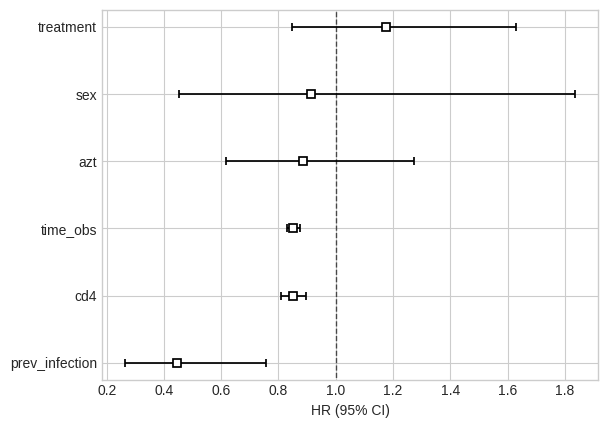

In [123]:
ax = linear_cox_model.plot(hazard_ratios=True)

#### <a id='toc1_2_1_7_'></a>[Partial effects on outcome](#toc0_)

##### <a id='toc1_2_1_7_1_'></a>[CD4](#toc0_)

The plot demonstrates the survival probabilities over time for individuals with varying CD4 counts. Higher CD4 levels (e.g., 17) are associated with significantly better survival outcomes compared to lower levels (e.g., 1). The steep decline in survival probability for lower CD4 counts highlights their critical role in predicting survival. The baseline curve provides a useful reference, showing how changes in CD4 count influence survival probabilities relative to the average individual.

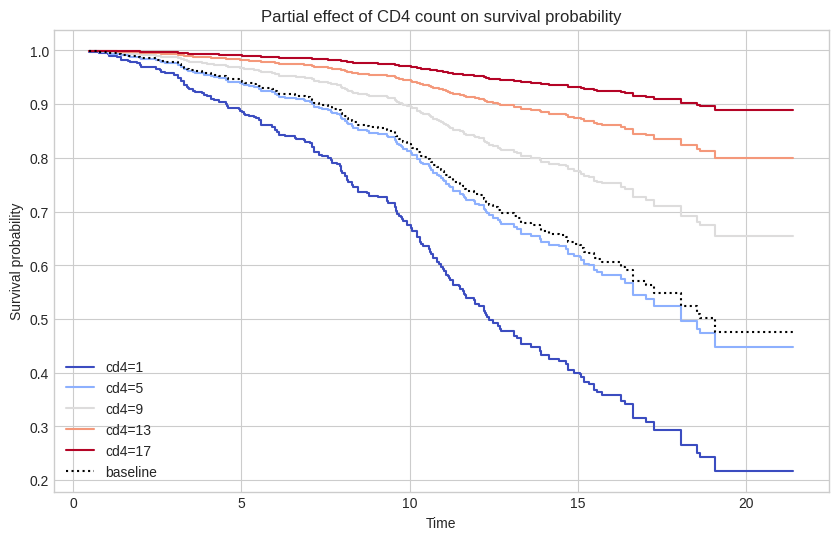

In [124]:
from numpy import arange

cd4_values = arange(1, 20, 4)
ax = linear_cox_model.plot_partial_effects_on_outcome(
    covariates='cd4',
    values=cd4_values,
    cmap='coolwarm'
)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time")
ax.set_title("Partial effect of CD4 count on survival probability")
ax.figure.set_size_inches(10, 6)

##### <a id='toc1_2_1_7_2_'></a>[Treatment](#toc0_)

This plot compares survival probabilities over time for individuals treated with two medications, ddC (blue) and ddI (red). Individuals on ddC exhibit slightly better survival probabilities than those on ddI, particularly as time progresses. The divergence between the curves becomes more noticeable after approximately 10 months, suggesting that ddC might be more effective in prolonging survival in the long term.

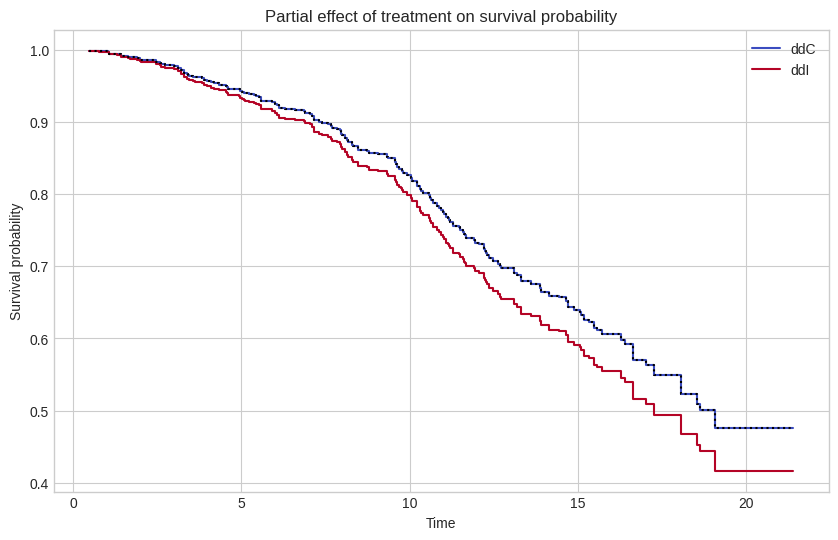

In [125]:
treatment_values = [
    0,  # ddc
    1,  # ddl
]
treatment_names = encoder.categories_[categorical_cols.index("treatment")]

ax = linear_cox_model.plot_partial_effects_on_outcome(
    covariates='treatment',
    values=treatment_values,
    cmap='coolwarm'
)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time")
ax.set_title("Partial effect of treatment on survival probability")
ax.legend(treatment_names)
ax.figure.set_size_inches(10, 6)

##### <a id='toc1_2_1_7_3_'></a>[Sex](#toc0_)

This graph shows the partial effect of sex on survival probability over time. The blue line represents the survival probability for females, while the red line represents the survival probability for males. Both lines start at around 1.0 and gradually decline over time. The plot suggests that males have a slightly higher survival probability compared to females.

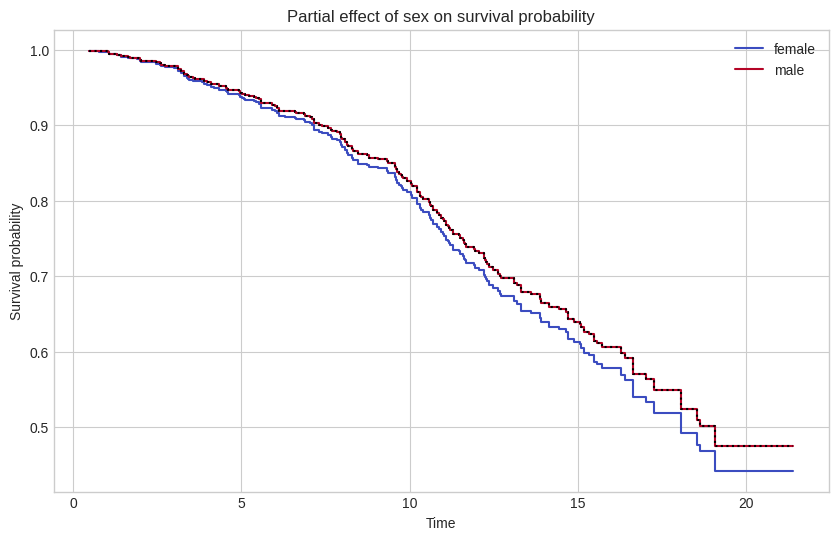

In [126]:
sex_values = [
    0,  # Female
    1,  # Male
]
sex_names = encoder.categories_[categorical_cols.index("sex")]

ax = linear_cox_model.plot_partial_effects_on_outcome(
    covariates='sex',
    values=sex_values,
    cmap='coolwarm'
)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time")
ax.set_title("Partial effect of sex on survival probability")
ax.legend(sex_names)
ax.figure.set_size_inches(10, 6)

##### <a id='toc1_2_1_7_4_'></a>[Previous infection](#toc0_)

This graph illustrates the partial effect of prey_infection on survival probability over time. The red line represents individuals without AIDS, while the blue line represents those with AIDS. The plot indicates that individuals without AIDS consistently have a higher survival probability compared to those with AIDS.

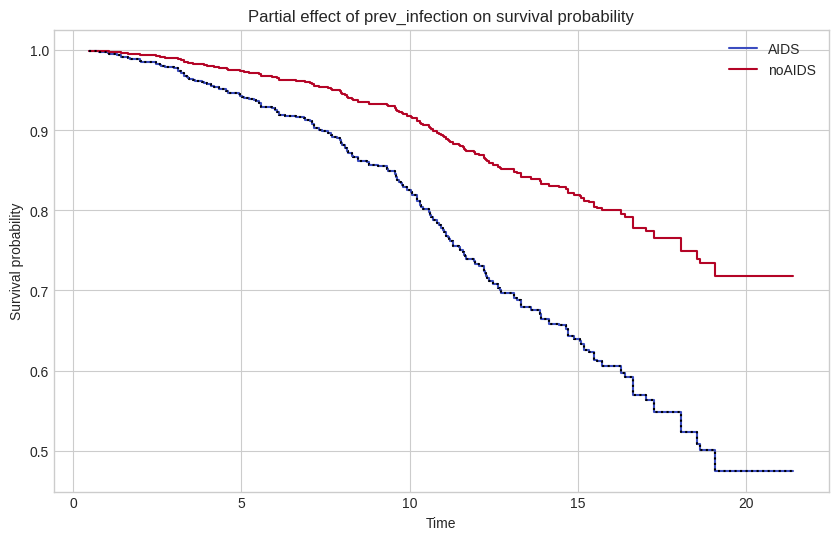

In [127]:
prev_infection_values = [
    0,  # AIDS
    1,  # No AIDS
]
prev_infection_names = encoder.categories_[
    categorical_cols.index("prev_infection")]

ax = linear_cox_model.plot_partial_effects_on_outcome(
    covariates='prev_infection',
    values=prev_infection_values,
    cmap='coolwarm'
)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time")
ax.set_title("Partial effect of prev_infection on survival probability")
ax.legend(prev_infection_names)
ax.figure.set_size_inches(10, 6)

##### <a id='toc1_2_1_7_5_'></a>[AZT](#toc0_)

This graph demonstrates the partial effect of AZT on survival probability over time. The blue line represents individuals experiencing treatment failure, while the red line represents those experiencing treatment intolerance. The plot suggests that individuals with intolerance have a slightly higher survival probability than those with failure throughout the observed period.

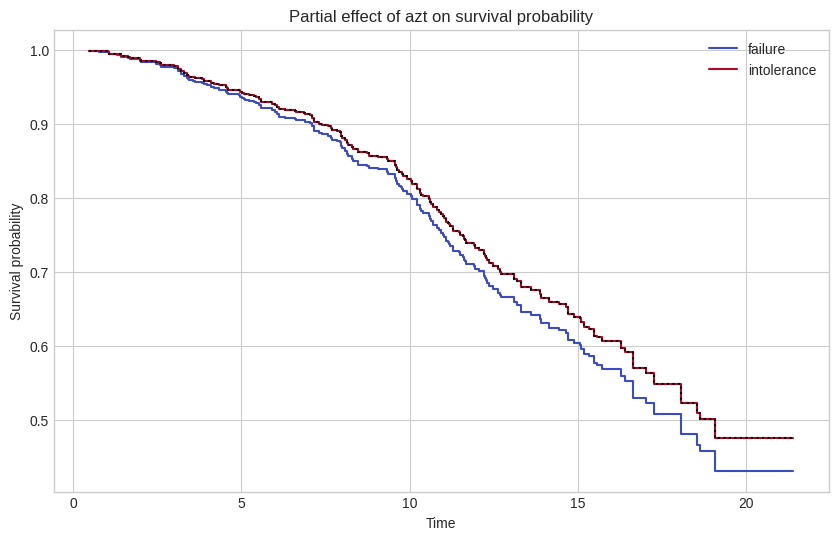

In [128]:
azt_values = [
    0,  # Failure
    1,  # Intolerance
]
azt_names = encoder.categories_[
    categorical_cols.index("azt")]

ax = linear_cox_model.plot_partial_effects_on_outcome(
    covariates='azt',
    values=azt_values,
    cmap='coolwarm'
)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time")
ax.set_title("Partial effect of azt on survival probability")
ax.legend(azt_names)
ax.figure.set_size_inches(10, 6)

### <a id='toc1_2_2_'></a>[Variant 2 : Complex relationship](#toc0_)

In [129]:
formula = """
    cd4 + I(cd4**2) + treatment + sex +
    prev_infection + azt + cd4 * treatment +
    sex * prev_infection
"""
non_linear_cox_model = CoxPHFitter()
non_linear_cox_model.fit(
    train_df,
    duration_col='time',
    event_col='death',
    formula=formula,
    cluster_col='subject',
    show_progress=True
)

Iteration 1: norm_delta = 1.37e+00, step_size = 0.9500, log_lik = -2205.91082, newton_decrement = 8.82e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.80e-01, step_size = 0.9500, log_lik = -2113.86970, newton_decrement = 6.42e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.65e-01, step_size = 0.9500, log_lik = -2106.67959, newton_decrement = 6.81e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.42e-02, step_size = 1.0000, log_lik = -2105.94098, newton_decrement = 1.43e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.04e-03, step_size = 1.0000, log_lik = -2105.92644, newton_decrement = 7.81e-06, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.72e-07, step_size = 1.0000, log_lik = -2105.92644, newton_decrement = 2.37e-12, seconds_since_start = 0.0
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 1124 total observations, 794 right-censored observations>

#### <a id='toc1_2_2_1_'></a>[Print summary of the results](#toc0_)

In [130]:
non_linear_cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 1124 total observations, 794 right-censored observations>
             duration col = 'time'
                event col = 'death'
              cluster col = 'subject'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1124
number of events observed = 330
   partial log-likelihood = -2105.93
         time fit was run = 2024-12-05 10:31:41 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
cd4                              -0.14      0.87      0.07           -0.28            0.00                0.75                1.00
I(cd4 ** 2)                      -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
treatment[T.1.0]                  0.04      1.04      0.29           -0.52            0.60                0.59                1.82
sex[T.1.0]                       -0.09      0.91      0.40           -0.87            0.69                0.42                1.99
prev_infection[T.1.0]            -0.45      0.64      0.71           -1.84            0.94                0.16                2.56
azt[T.1.0]                       -0.07      0.94      0.20           -0.45            0.32                0.64                1.37
cd4:treatment[T.1.0]              0.02      1.03      0.05           -0.07            0.12                0.93                1.13
sex[T.1.0]:prev_infection[T.1.0] -0.64      0.53      0.75           -2.12            0.84                0.12                2.32

                                  cmp to     z    p  -log2(p)
covariate                                                    
cd4                                 0.00 -1.93 0.05      4.24
I(cd4 ** 2)                         0.00 -0.03 0.98      0.04
treatment[T.1.0]                    0.00  0.13 0.90      0.16
sex[T.1.0]                          0.00 -0.24 0.81      0.30
prev_infection[T.1.0]               0.00 -0.63 0.53      0.93
azt[T.1.0]                          0.00 -0.34 0.74      0.44
cd4:treatment[T.1.0]                0.00  0.52 0.61      0.72
sex[T.1.0]:prev_infection[T.1.0]    0.00 -0.85 0.40      1.33
---
Concordance = 0.72
Partial AIC = 4227.85
log-likelihood ratio test = 199.97 on 8 df
-log2(p) of ll-ratio test = 126.86

#### <a id='toc1_2_2_2_'></a>[Test the model](#toc0_)

The non-linear model did not perform as well as the linear model on the test set.

In [131]:
non_linear_cox_model_concordance_score = non_linear_cox_model.score(
    test_df,
    scoring_method="concordance_index"
)
non_linear_cox_model_concordance_score

np.float64(0.6498708010335917)

In [132]:
non_linear_cox_model_log_likelihood_score = non_linear_cox_model.score(
    test_df,
    scoring_method="log_likelihood"
)
non_linear_cox_model_log_likelihood_score

np.float64(-1.487633258895102)

In [133]:
from sklearn.metrics import brier_score_loss

test_times = test_df['time'].values
predicted_survival_prob = non_linear_cox_model.predict_survival_function(
    test_df)

brier_scores = []
time_grid = np.linspace(0, test_times.max(), 100)
for t in time_grid:
    survival_prob_at_t = predicted_survival_prob.apply(
        lambda s: np.interp(t, s.index, s.values))

    brier_score = brier_score_loss(
        y_true=(test_df['time'] <= t) & (test_df['death'] == 1),
        y_prob=1 - survival_prob_at_t
    )
    brier_scores.append(brier_score)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=time_grid,
        y=brier_scores,
        mode='lines',
        name='Brier Score',
        line=dict(color='#1F77B4', width=3)
    )
)

fig.update_layout(
    title={
        'text': 'Brier Score as a Function of Time',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time',
    yaxis_title='Brier Score',
    width=1000,
    height=600,
    plot_bgcolor='white',

    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1
    ),

    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='lightgrey',
        borderwidth=1
    )
)

fig.update_traces(
    hovertemplate='Time: %{x:.2f}<br>Brier Score: %{y:.4f}<extra></extra>'
)

fig.show()

### <a id='toc1_2_3_'></a>[Compare the scores for the 2 variants](#toc0_)

The `concordance index` (C-index) is an extension of the `AUC` and is a metric that should be maximized. As noted in the [lifelines documentation](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#concordance-index), fitted survival models typically achieve a concordance index within the range of `0.55` to `0.75`.

Our models perform within this range, with a concordance index of approximately `0.73`. The linear model outperforms the non-linear Cox model, achieving a value of `0.732386` compared to `0.649871`.

The `log-likelihood`, another metric to be maximized, shows similar result: the linear model achieves the better value of `-1.443152`, while the non-linear model achieves `-1.487633`.

In conclusion, the linear model demonstrate good predictive capability.

In [134]:
scores_df = pd.DataFrame({
    "model": ["linear", "non_linear"],
    "concordance": [linear_cox_model_concordance_score, non_linear_cox_model_concordance_score],
    "log_likelihood": [linear_cox_model_log_likelihood_score, non_linear_cox_model_log_likelihood_score]
})


def color_concordance_score(val):
    max_val = scores_df["concordance"].max()
    color = 'green' if val == max_val else ''
    return f'background-color: {color}'


def color_log_likelihood_score(val):
    max_val = scores_df["log_likelihood"].max()
    color = 'green' if val == max_val else ''
    return f'background-color: {color}'


results_df = scores_df.style.map(color_concordance_score, subset=["concordance"]) \
                            .map(color_log_likelihood_score, subset=["log_likelihood"])

results_df

,model,concordance,log_likelihood
0,linear,0.732386,-1.443152
1,non_linear,0.649871,-1.487633


In [135]:
test_times = test_df['time'].values

predicted_survival_prob_linear = linear_cox_model.predict_survival_function(
    test_df)
brier_scores_linear = []
time_grid = np.linspace(0, test_times.max(), 100)

for t in time_grid:
    survival_prob_at_t = predicted_survival_prob_linear.apply(
        lambda s: np.interp(t, s.index, s.values)
    )
    brier_score = brier_score_loss(
        y_true=(test_df['time'] <= t) & (test_df['death'] == 1),
        y_prob=1 - survival_prob_at_t
    )
    brier_scores_linear.append(brier_score)

predicted_survival_prob_non_linear = non_linear_cox_model.predict_survival_function(
    test_df)
brier_scores_non_linear = []

for t in time_grid:
    survival_prob_at_t = predicted_survival_prob_non_linear.apply(
        lambda s: np.interp(t, s.index, s.values)
    )
    brier_score = brier_score_loss(
        y_true=(test_df['time'] <= t) & (test_df['death'] == 1),
        y_prob=1 - survival_prob_at_t
    )
    brier_scores_non_linear.append(brier_score)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=time_grid,
        y=brier_scores_linear,
        mode='lines',
        name='Linear Cox Brier Score',
        line=dict(color='#1F77B4', width=3)
    )
)

fig.add_trace(
    go.Scatter(
        x=time_grid,
        y=brier_scores_non_linear,
        mode='lines',
        name='Non-linear Cox Brier Score',
        line=dict(color='#FF7F0E', width=3)
    )
)

fig.update_layout(
    title={
        'text': 'Brier Score Comparison for Linear and Non-linear Cox Models',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time',
    yaxis_title='Brier Score',
    width=1000,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='lightgrey',
        borderwidth=1
    )
)

fig.update_traces(
    hovertemplate='Time: %{x:.2f}<br>Brier Score: %{y:.4f}<extra></extra>'
)

fig.show()
fig.write_image("brier_score_comparison_cox_models.svg")

## <a id='toc1_3_'></a>[Training with Random Survival Forest](#toc0_)

### <a id='toc1_3_1_'></a>[Encoding numerical features](#toc0_)

In [136]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ['cd4']

scaler = StandardScaler()
scaler.fit(x_train[numerical_cols])

x_train.loc[:, numerical_cols] = scaler.transform(x_train[numerical_cols])
x_test.loc[:, numerical_cols] = scaler.transform(x_test[numerical_cols])

### <a id='toc1_3_2_'></a>[Variant 1 : Default hyperparameters](#toc0_)

#### <a id='toc1_3_2_1_'></a>[Concordance index](#toc0_)

In [137]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

rsf = RandomSurvivalForest(random_state=42)
rsf.fit(x_train, y_train)

c_index = concordance_index_censored(
    y_test['death'],
    y_test['time'],
    rsf.predict(x_test)
)
print("Concordance Index:", c_index[0])

Concordance Index: 0.7569336778639104


#### <a id='toc1_3_2_2_'></a>[Factors importance](#toc0_)

The results indicate that the `CD4 cell count` is the most significant feature by a considerable margin, while sex is the least significant. This aligns well with the findings from the Cox model.

In [138]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rsf, x_test, y_test, n_repeats=15, random_state=42)
result_df = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=x_test.columns,
).sort_values(by="importances_mean", ascending=False)
result_df = result_df.drop("subject", axis=0)
result_df

,importances_mean,importances_std
cd4,0.082299,0.014950
time_obs,0.075223,0.020047
prev_infection,0.028849,0.011099
treatment,0.017410,0.006474
azt,0.014742,0.006576
sex,0.006642,0.003426


#### <a id='toc1_3_2_3_'></a>[Brier score](#toc0_)

The Brier score comparison shows that the curve for the Random Survival Forest (RSF) consistently remains lower than those of the two Cox model variants, highlighting the superior performance of RSF compared to the Cox models.

In [139]:
test_times = test_df['time'].values

predicted_survival_prob_linear = linear_cox_model.predict_survival_function(
    test_df)
brier_scores_linear = []
time_grid = np.linspace(0, test_times.max(), 100)

for t in time_grid:
    survival_prob_at_t = predicted_survival_prob_linear.apply(
        lambda s: np.interp(t, s.index, s.values)
    )
    brier_score = brier_score_loss(
        y_true=(test_df['time'] <= t) & (test_df['death'] == 1),
        y_prob=1 - survival_prob_at_t
    )
    brier_scores_linear.append(brier_score)

predicted_survival_prob_non_linear = non_linear_cox_model.predict_survival_function(
    test_df)
brier_scores_non_linear = []

for t in time_grid:
    survival_prob_at_t = predicted_survival_prob_non_linear.apply(
        lambda s: np.interp(t, s.index, s.values)
    )
    brier_score = brier_score_loss(
        y_true=(test_df['time'] <= t) & (test_df['death'] == 1),
        y_prob=1 - survival_prob_at_t
    )
    brier_scores_non_linear.append(brier_score)


predicted_survival_rsf = rsf.predict_survival_function(x_test)
brier_scores_rsf = []

time_grid = np.linspace(0, test_times.max(), 100)
for t in time_grid:
    survival_prob_at_t = np.array(
        [np.interp(t, fn.x, fn.y) for fn in predicted_survival_rsf])
    brier_score = brier_score_loss(
        y_true=(y_test['time'] <= t) & (y_test['death'] == 1),
        y_prob=1 - survival_prob_at_t
    )
    brier_scores_rsf.append(brier_score)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=time_grid,
        y=brier_scores_linear,
        mode='lines',
        name='Linear Cox Brier Score',
        line=dict(color='#1F77B4', width=3)
    )
)

fig.add_trace(
    go.Scatter(
        x=time_grid,
        y=brier_scores_non_linear,
        mode='lines',
        name='Non-linear Cox Brier Score',
        line=dict(color='#FF7F0E', width=3)
    )
)

fig.add_trace(
    go.Scatter(
        x=time_grid,
        y=brier_scores_rsf,
        mode='lines',
        name='Random Survival Forest Brier Score',
        line=dict(color='#000000', width=3)
    )
)

fig.update_layout(
    title={
        'text': 'Brier Score Comparison for Cox Models and Random Survival Forest',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time',
    yaxis_title='Brier Score',
    width=1000,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='lightgrey',
        borderwidth=1
    )
)

fig.update_traces(
    hovertemplate='Time: %{x:.2f}<br>Brier Score: %{y:.4f}<extra></extra>'
)

fig.show()
fig.write_image("brier_score_comparison_cox_models_rsf.svg")

### <a id='toc1_3_3_'></a>[Variant 2 : Hyperparameter tuning](#toc0_)

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sksurv.metrics import as_concordance_index_ipcw_scorer

param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

rsf = RandomSurvivalForest(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = GridSearchCV(
    param_grid=param_grid,
    estimator=as_concordance_index_ipcw_scorer(rsf),
    cv=skf,
)

random_search.fit(x_train, y_train)

best_rsf = random_search.best_estimator_

In [141]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

rsf = RandomSurvivalForest(
    random_state=42,
    n_estimators=40,
    min_samples_leaf=8,
    min_samples_split=20
)
rsf.fit(x_train, y_train)

c_index = concordance_index_censored(
    y_test['death'],
    y_test['time'],
    rsf.predict(x_test)
)
print("Concordance Index:", c_index[0])

Concordance Index: 0.7505024404249211


## <a id='toc1_4_'></a>[Interpretation of the fitted models](#toc0_)

### <a id='toc1_4_1_'></a>[Survival probability beyond 18 months](#toc0_)

We are comparing two individuals. The first individual is a **male patient** with a **CD4 count of 15.7**, observed at the 6-month mark of the study. He is being treated with **ddC**, has a history of **AIDS**, and experienced **AZT treatment failure**.

The second individual is a **female patient** with a **CD4 count of 1.7**, also observed at the 6-month mark. She is being treated with **ddI**, has a history of **AIDS**, and tolerated the **AZT treatment**.

Using the **Cox model**, we predicted the survival function for both individuals and found that their probabilities of surviving beyond 18 months differ. The **male patient** has a higher survival probability of **0.933**, while the **female patient** has a lower probability of **0.4737**.

This difference is explained by the **CD4 counts**. The **female patient’s very low CD4 count** at the 6-month mark suggests a **deteriorating condition**, which lowers her chances of survival. In contrast, the **male patient’s higher CD4 count** indicates a **better immune response**, significantly boosting his probability of surviving beyond 18 months.

In [142]:
representative_individual1 = {
    'subject': 500,
    'cd4': 15.7,
    'treatment': 0,  # 0: ddC, 1: ddI
    'prev_infection': 0,  # 0: AIDS, 1: No AIDS
    'time_obs': 6,
    'sex': 1,  # 0: Female, 1: Male
    'azt': 0  # 0: Failure, 1: Intolerance
}

representative_individual2 = {
    'subject': 501,
    'cd4': 1.7,
    'treatment': 1,
    'prev_infection': 0,
    'time_obs': 6,
    'sex': 0,
    'azt': 1
}

representative_individual_df1 = pd.DataFrame(
    representative_individual1, columns=train_df.columns, index=[0])
representative_individual_df2 = pd.DataFrame(
    representative_individual2, columns=train_df.columns, index=[1])

combined_df = pd.concat(
    [representative_individual_df1, representative_individual_df2])

predictions = linear_cox_model.predict_survival_function(combined_df)

survival_function1 = predictions.iloc[:, 0]
survival_function2 = predictions.iloc[:, 1]

# Interpolate survival probabilities at 18 months
time_points = survival_function1.index.values
survival_prob_18_months1 = np.interp(
    18, time_points, survival_function1.values)
survival_prob_18_months2 = np.interp(
    18, time_points, survival_function2.values)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=time_points,
        y=survival_function1.values,
        mode='lines',
        name='Patient 1 survival probability',
        line=dict(color='#1F77B4', width=3),
    )
)

fig.add_trace(
    go.Scatter(
        x=[0, 18, 18],
        y=[survival_prob_18_months1, survival_prob_18_months1, 0],
        mode='lines',
        name='Patient 1: 18-month survival probability',
        line=dict(color='#1F77B4', dash='dot'),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=[18],
        y=[survival_prob_18_months1],
        mode='markers',
        marker=dict(color='#1F77B4', size=10),
        name='Patient 1: Survival probability at 18 months'
    )
)

fig.add_trace(
    go.Scatter(
        x=time_points,
        y=survival_function2.values,
        mode='lines',
        name='Patient 2 survival Probability',
        line=dict(color='#FF7F0E', width=3),
    )
)

fig.add_trace(
    go.Scatter(
        x=[0, 18, 18],
        y=[survival_prob_18_months2, survival_prob_18_months2, 0],
        mode='lines',
        name='Patient 2: 18-month survival probability',
        line=dict(color='#FF7F0E', dash='dot'),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=[18],
        y=[survival_prob_18_months2],
        mode='markers',
        marker=dict(color='#FF7F0E', size=10),
        name='Patient 2: Survival probability at 18 months'
    )
)

fig.update_layout(
    title={
        'text': 'Survival function comparison',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='Survival probability',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="bottom",
        y=0.01,
        xanchor="left",
        x=0.01
    )
)

fig.add_annotation(
    x=18,
    y=survival_prob_18_months1,
    text=f'<b>Patient 1 survival prob at 18 months: {
        survival_prob_18_months1:.4f}</b>',
    showarrow=True,
    arrowhead=2,
    font=dict(color='#000000')
)

fig.add_annotation(
    x=18,
    y=survival_prob_18_months2,
    text=f'<b>Patient 2 survival prob at 18 months: {
        survival_prob_18_months2:.4f}</b>',
    showarrow=True,
    arrowhead=2,
    font=dict(color='#000000')
)

fig.show()

print(
    f"Patient 1 - Survival probability at 18 months: {survival_prob_18_months1:.4f}")
print(
    f"Patient 2 - Survival probability at 18 months: {survival_prob_18_months2:.4f}")

Patient 1 - Survival probability at 18 months: 0.9330
Patient 2 - Survival probability at 18 months: 0.4737


Now, if we modify the **female patient's previous infection** factor to **No AIDS**, the situation changes. The probability of surviving beyond 18 months increases from **0.4737** to **0.7167**. This supports the conclusion that the key factors affecting the survival probability of patients, as identified through the **Cox model**, are indeed accurate.

In [143]:
representative_individual1 = {
    'subject': 500,
    'cd4': 15.7,
    'treatment': 0,  # 0: ddC, 1: ddI
    'prev_infection': 0,  # 0: AIDS, 1: No AIDS
    'time_obs': 6,
    'sex': 1,  # 0: Female, 1: Male
    'azt': 0  # 0: Failure, 1: Intolerance
}

representative_individual2 = {
    'subject': 501,
    'cd4': 1.7,
    'treatment': 1,
    'prev_infection': 1,
    'time_obs': 6,
    'sex': 0,
    'azt': 1
}

representative_individual_df1 = pd.DataFrame(
    representative_individual1, columns=train_df.columns, index=[0])
representative_individual_df2 = pd.DataFrame(
    representative_individual2, columns=train_df.columns, index=[1])

combined_df = pd.concat(
    [representative_individual_df1, representative_individual_df2])

predictions = linear_cox_model.predict_survival_function(combined_df)

survival_function1 = predictions.iloc[:, 0]
survival_function2 = predictions.iloc[:, 1]

# Interpolate survival probabilities at 18 months
time_points = survival_function1.index.values
survival_prob_18_months1 = np.interp(
    18, time_points, survival_function1.values)
survival_prob_18_months2 = np.interp(
    18, time_points, survival_function2.values)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=time_points,
        y=survival_function1.values,
        mode='lines',
        name='Patient 1 survival probability',
        line=dict(color='#1F77B4', width=3),
    )
)

fig.add_trace(
    go.Scatter(
        x=[0, 18, 18],
        y=[survival_prob_18_months1, survival_prob_18_months1, 0],
        mode='lines',
        name='Patient 1: 18-month survival probability',
        line=dict(color='#1F77B4', dash='dot'),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=[18],
        y=[survival_prob_18_months1],
        mode='markers',
        marker=dict(color='#1F77B4', size=10),
        name='Patient 1: Survival probability at 18 months'
    )
)

fig.add_trace(
    go.Scatter(
        x=time_points,
        y=survival_function2.values,
        mode='lines',
        name='Patient 2 survival Probability',
        line=dict(color='#FF7F0E', width=3),
    )
)

fig.add_trace(
    go.Scatter(
        x=[0, 18, 18],
        y=[survival_prob_18_months2, survival_prob_18_months2, 0],
        mode='lines',
        name='Patient 2: 18-month survival probability',
        line=dict(color='#FF7F0E', dash='dot'),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=[18],
        y=[survival_prob_18_months2],
        mode='markers',
        marker=dict(color='#FF7F0E', size=10),
        name='Patient 2: Survival probability at 18 months'
    )
)

fig.update_layout(
    title={
        'text': 'Survival function comparison',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='Survival probability',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="bottom",
        y=0.01,
        xanchor="left",
        x=0.01
    )
)

fig.add_annotation(
    x=18,
    y=survival_prob_18_months1,
    text=f'<b>Patient 1 survival prob at 18 months: {
        survival_prob_18_months1:.4f}</b>',
    showarrow=True,
    arrowhead=2,
    font=dict(color='#000000')
)

fig.add_annotation(
    x=18,
    y=survival_prob_18_months2,
    text=f'<b>Patient 2 survival prob at 18 months: {
        survival_prob_18_months2:.4f}</b>',
    showarrow=True,
    arrowhead=2,
    font=dict(color='#000000')
)

fig.show()

print(
    f"Patient 1 - Survival probability at 18 months: {survival_prob_18_months1:.4f}")
print(
    f"Patient 2 - Survival probability at 18 months: {survival_prob_18_months2:.4f}")

Patient 1 - Survival probability at 18 months: 0.9330
Patient 2 - Survival probability at 18 months: 0.7167


When varying the CD4 cell count from **1 to 14**, we observe a significant increase in the probability of survival, starting at **0.1125** and reaching **0.7267**. This highlights the critical role that **CD4 cell count** plays as a key factor influencing survival outcomes.

In [144]:
cd4_values = np.arange(1, 14, 4)

representative_individual = {
    'subject': 501,
    'cd4': 1.7,
    'treatment': 1,
    'prev_infection': 0,
    'time_obs': 0,
    'sex': 0,
    'azt': 1
}

fig = go.Figure()
for cd4 in cd4_values:
    representative_individual['cd4'] = cd4

    representative_individual_df = pd.DataFrame(
        representative_individual, columns=train_df.columns, index=[0]
    )
    predictions = linear_cox_model.predict_survival_function(
        representative_individual_df)
    survival_function = predictions.iloc[:, 0]  # We have only one patient

    # Interpolate survival probabilities at 18 months
    time_points = survival_function.index.values
    survival_prob_18_months = np.interp(
        18, time_points, survival_function.values)

    fig.add_trace(
        go.Scatter(
            x=time_points,
            y=survival_function.values,
            mode='lines',
            name=f'Patient with CD4={cd4}',
            line=dict(width=3)
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[0, 18, 18],
            y=[survival_prob_18_months, survival_prob_18_months, 0],
            mode='lines',
            name='Survival probability',
            line=dict(color='#1F77B4', dash='dot'),
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[18],
            y=[survival_prob_18_months],
            mode='markers',
            marker=dict(size=10),
            name=f'CD4={cd4} at 18 months'
        )
    )

    fig.add_annotation(
        x=18,
        y=survival_prob_18_months,
        text=f'<b>Probability: {survival_prob_18_months:.4f}</b>',
        showarrow=True,
        arrowhead=2,
        font=dict(color='#000000')
    )

fig.update_layout(
    title={
        'text': 'Survival function for varying CD4 counts',
        'font': dict(size=16, family='Arial, bold'),
        'x': 0.5,
        'xanchor': 'center'
    },
    font=dict(family='Arial', size=12),
    xaxis_title='Time (months)',
    yaxis_title='Survival probability',
    width=1000,
    height=600,
    plot_bgcolor='white',
    legend=dict(
        yanchor="bottom",
        y=0.01,
        xanchor="left",
        x=0.01
    )
)

fig.show()

### <a id='toc1_4_2_'></a>[Conditional survival probability](#toc0_)

- Theoretical Difference:
  - **Unconditional Probability** reflects survival over the entire timeline.
  - **Conditional Probability** accounts for having already survived 12 months, thereby **adjusting for improved survival odds** due to resilience.

- Practical Implication:
  - The conditional survival estimate is **higher**, highlighting that past survival improves future survival probabilities, likely due to the individual's resilience or favorable response to treatment.


In [145]:
representative_individual1 = {
    'subject': 500,
    'cd4': 15.7,
    'treatment': 0,  # 0: ddC, 1: ddI
    'prev_infection': 0,  # 0: AIDS, 1: No AIDS
    'time_obs': 6,
    'sex': 1,  # 0: Female, 1: Male
    'azt': 0  # 0: Failure, 1: Intolerance
}

representative_individual2 = {
    'subject': 501,
    'cd4': 1.7,
    'treatment': 1,
    'prev_infection': 0,
    'time_obs': 6,
    'sex': 0,
    'azt': 1
}

representative_individual_df1 = pd.DataFrame(
    representative_individual1, columns=train_df.columns, index=[0])
representative_individual_df2 = pd.DataFrame(
    representative_individual2, columns=train_df.columns, index=[1])

combined_df = pd.concat(
    [representative_individual_df1, representative_individual_df2])

predictions = linear_cox_model.predict_survival_function(combined_df)

survival_function1 = predictions.iloc[:, 0]
survival_function2 = predictions.iloc[:, 1]

# Calculate survival probability at 12 months
survival_prob_12_months1 = np.interp(
    12, time_points, survival_function1.values)
survival_prob_12_months2 = np.interp(
    12, time_points, survival_function2.values)

# Calculate survival probability at 18 months (12 + 6 months)
survival_prob_18_months1 = np.interp(
    18, time_points, survival_function1.values)
survival_prob_18_months2 = np.interp(
    18, time_points, survival_function2.values)

# Calculate conditional probability
conditional_survival_prob1 = survival_prob_18_months1 / survival_prob_12_months1
conditional_survival_prob2 = survival_prob_18_months2 / survival_prob_12_months2

print(f"Patient 1 - Conditional survival probability for next 6 months: {
      conditional_survival_prob1:.4f}")
print(f"Patient 2 - Conditional survival probability for next 6 months: {
      conditional_survival_prob2:.4f}")

Patient 1 - Conditional survival probability for next 6 months: 0.9673
Patient 2 - Conditional survival probability for next 6 months: 0.6992


## <a id='toc1_5_'></a>[Conclusion](#toc0_)

We explored survival analysis using the HIV dataset, we used both Cox proportional hazards models (linear and non-linear variants) and Random Survival Forests. We performed extensive exploratory data analysis, revealing key relationships between variables such as CD4 count, previous infection status, and survival time.

The linear Cox model showed superior performance compared to the non-linear variant, demonstrating good predictive ability as measured by the concordance index and log-likelihood. Furthermore, Random Survival Forests achieved even better predictive performance, as indicated by a lower Brier score and C-index compared to both Cox models.

The analysis highlighted the importance of CD4 count as the most influential predictor of survival. We also demonstrated the practical application of the models by predicting survival probabilities and conditional survival probabilities for representative individuals, illustrating how varying factors like CD4 count and previous infection status affect survival outcomes.